# Personal Information
Name: **Anh Tran**

StudentID: **12770698**

Email: [**anh.tran1@student.uva.nl**](anh.tran1@student.uva.nl)

Github: https://github.com/atran13/MSc-Thesis-Gentrification-and-storefront-signage 

Submitted on: **19.03.2023**

# Data Context

The topic of this research is to explore gentrification - the process of a neighborhood changing as a result of wealthier residents moving in, bringing investments and physical improvements, but displacing existing residents as prices rise and cultures homogenized or replaced. This project examines the visual indicators of gentrification, more specifically in the signage of storefronts in Amsterdam, by applying computer vision methods on images of facades in the city.

The image dataset used in this project is from the [StreetSwipe project](http://streetswipe.aestheticsofexclusion.com/about.php). Via crowd-sourcing, the project lets people decide which facade is gentrified, by voting "Yes" or "No" on the streetview images. The official *gentrified* and *non-gentrified* labels are generated based the majority of votes for each facade. Additionally, if subsequent voters decide against the majority, they are prompted to provide a textual explanation for their vote (mismatch responses).

On this data, scene-text detection will be applied to identify the regions of the images that contain the storefront signage (if any). With the text region extracted (still as an image), font, color, and text recognition will be done to understand these attributes. This pipeline will be applied on gentrified and non-gentrified labelled data, and ultimately the learnt attributes (fonts, colors, semantics) of these classes are compared to understand what is seen as gentrified.

In [20]:
# Imports
import os, sys
import shutil 
import numpy as np
import pandas as pd
import glob
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import whratio
import xml.etree.ElementTree as ET
import xml.dom.minidom
%matplotlib inline

# Data Description
The data is divided into two subsets, generally called pre-July 2020 and post-July 2020. This is because there are two versions of the StreetSwipe data collection tool. There are 2441 images in total - 1912 images in the older version (pre-July 2020) and 529 in the new one (post-July 2020). While the images from the pre-July 2020 subset are available directly, those from the new version are stored in a Google APIs bucket - these were scraped via the URLs provided by the project owner. Each image has metadata on the facade's location (latitude and longitude) and street name. The new version's images also have more detailed address, name and type of business/services. 

In terms of data generated from StreetSwipe's tool, these are stored in multiple CSV files. All images have corresponding data entries on the numbers of "yes" and "no" votes for gentrification. In addition, each individual response is recorded with an unique response ID, along with the image ID, the vote (yes/no). Lastly, mismatch responses are also recorded with an unique response ID, image ID, the vote (yes/no), and the textual answer given by the voter.

Since the main interest of the research is to learn visual patterns from the labeled facades, the data that will be further processed and discussed in this analysis consists only of the images and the CSV files with votes for each image. These data are loaded and discussed below, divided into the pre- and post-July 2020 subsets.

## Labels
Because the images are not annotated with the ground truth of interest (text bounding boxes, text string, font and color), evaluation of feature extraction will be done via visual inspection and dimensionality reduction. The labels discussed here are the gentrified/non-gentrified labels. Below is an overview into the shape of the main data frames of interest - ones that indicate the number of gentrified/non-gentrified votes per image. 

In [43]:
# Load data
# Pre-July 2020 votes
scores_pre = pd.read_csv("StreetSwipe/database/pre_202007/ss_afb_scores.csv", names = ['id','yes','no'] )
# Post-July 2020 votes
scores_post = pd.read_csv("StreetSwipe/database/post_202007/ss_afb_scores.csv", names = ['id','yes','no'] )

print("Pre-July 2020"); print(scores_pre.head())
print()
print("Post-July 2020"); print(scores_post.head())

Pre-July 2020
   id  yes  no
0   1    0   3
1   2    0   2
2   3    0   1
3   4    0   3
4   5    0   4

Post-July 2020
                               id  yes  no
0  faillissementsdossier:24368214    0   1
1  faillissementsdossier:33251073    5  74
2  faillissementsdossier:60624485    0  20
3  faillissementsdossier:63432250   34  56
4  faillissementsdossier:63453428   66   9


 As can be seen, there are more votes in the post-July 2020 version than in the older version. This does not directly introduce bias into the task of learning the characteristics present in the images; however, it is still worth noting as having more uniform amount of votes will better ensure the representativeness and generalizability of the results.

The following code creates a column for the *gentrified/non-gentrified* label based on the majority of votes for each image:

In [44]:
scores_pre["label"] = np.where(scores_pre['yes'] > scores_pre['no'], "gentrified", "non-gentrified")
scores_post["label"] = np.where(scores_post['yes'] > scores_post['no'], "gentrified", "non-gentrified")

print("Pre-July 2020"); print(scores_pre.head())
print()
print("Post-July 2020"); print(scores_post.head())

Pre-July 2020
   id  yes  no           label
0   1    0   3  non-gentrified
1   2    0   2  non-gentrified
2   3    0   1  non-gentrified
3   4    0   3  non-gentrified
4   5    0   4  non-gentrified

Post-July 2020
                               id  yes  no           label
0  faillissementsdossier:24368214    0   1  non-gentrified
1  faillissementsdossier:33251073    5  74  non-gentrified
2  faillissementsdossier:60624485    0  20  non-gentrified
3  faillissementsdossier:63432250   34  56  non-gentrified
4  faillissementsdossier:63453428   66   9      gentrified


#### Sample size per class
Below is a visualization of the sample size in two classes:

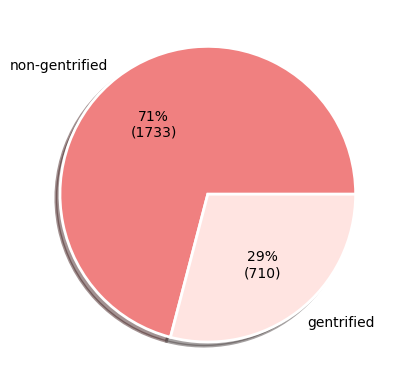

In [50]:
# concatenate into one dataframe for plotting
scores_all = pd.concat([scores_pre, scores_post], ignore_index=True)

# function for displaying counts and percentages
def autopct_format(values):
        def my_format(pct):
                total = sum(values)
                val = int(round(pct*total/100.0))
                return '{:.0f}%\n({v:d})'.format(pct, v=val)
        return my_format

# plot
values = scores_all['label'].value_counts().values
plt.pie(values,
        labels = scores_all['label'].value_counts().index,
        colors = ['lightcoral', 'mistyrose'],
        autopct = autopct_format(values), shadow = True,
        wedgeprops = {'linewidth': 2, 'edgecolor':'white'});

There is class imbalance in the data, with the gentrified facades accounting for just 29% of the dataset. Nonetheless, since the task is to extract attributes from the images, not classify gentrified/non-gentrified facades, this imbalance does not affect the reliability of the analyses.

Additionally, the total number of images calculated from the label data frames here is 2443, which is 2 more than what is in the image folders (2441), as noted in the beginning of this analysis. Upon checking the URLs provided to scrape the images, the number of items in total is 2441, so it is concluded that 2 images were not made available to the analysis dispite having been labelled, and these data entries will be disregarded moving forward.

#### Re-categorize image files
For the analysis, it is necessary that the images are separated per their labels. This would make it easier to extract and compare results between gentrified and non-gentrified storefronts. Therefore, based on the label columns, the images are re-categorized into corresponding folders.

Before the images can be moved, their IDs in the label data frames and their file names need to be modified to align to each other:

In [153]:
# Pre-July 2020 images

# Modifying the file names to match the IDs in label df
for file in glob.glob("StreetSwipe/images/img_pre/*.jpg"):
    img_filename = os.path.split(file)[1]
    img_id = str(int(img_filename.split('-')[0]))
    os.rename(file, os.path.join('StreetSwipe/images/img_pre/', img_id+'.jpg'))

In [45]:
# Modifying the IDs in label df to match file names
scores_pre['id'] = scores_pre['id'].astype(str) + '.jpg' ; scores_pre.head()

id  yes  no           label
0  1.jpg    0   3  non-gentrified
1  2.jpg    0   2  non-gentrified
2  3.jpg    0   1  non-gentrified
3  4.jpg    0   3  non-gentrified
4  5.jpg    0   4  non-gentrified

In [46]:
# Post-July 2020 images - Modifying the IDs in label df to match file names
scores_post['id'] = scores_post['id'].str.replace(':','-')
scores_post['id'] = scores_post['id'] + '.jpg' ; scores_post.head()

id  yes  no           label
0  faillissementsdossier-24368214.jpg    0   1  non-gentrified
1  faillissementsdossier-33251073.jpg    5  74  non-gentrified
2  faillissementsdossier-60624485.jpg    0  20  non-gentrified
3  faillissementsdossier-63432250.jpg   34  56  non-gentrified
4  faillissementsdossier-63453428.jpg   66   9      gentrified

The following code moves the images into their respective categories:

In [117]:
# Get class names and make corresponding directories
class_names = list(scores_all.label.unique())
for name in class_names:
    os.makedirs(os.path.join(name))

In [212]:
# Re-categorizing images from the pre-July 2020 subset
for name in class_names:
    for img in list(scores_pre[scores_pre['label'] == name]['id']):
        img_path = os.path.join('StreetSwipe/images/img_pre/', img)
        if os.path.exists(img_path):
            copy_image = shutil.copy(img_path, name)

In [216]:
# Re-categorizing images from the post-July 2020 subset
for name in class_names:
    for img in list(scores_post[scores_post['label'] == name]['id']):
        img_path = os.path.join('StreetSwipe/images/img_post/', img)
        if os.path.exists(img_path):
            copy_image = shutil.copy(img_path, name)

In [273]:
# Move new folders to new parent folder
new_folder = 'StreetSwipe/images_classified'
os.makedirs(os.path.join(new_folder))
for name in class_names:
    shutil.move(name, new_folder)

## Images
The following code loads the images per class, as well as creates a list of all images for ease of use in different analyses:

In [7]:
gentrified = [cv2.imread(file) for file in glob.glob("StreetSwipe/images_classified/gentrified/*.jpg")]
gentrified = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in gentrified] # correct the color channel

non_gentrified = [cv2.imread(file) for file in glob.glob("StreetSwipe/images_classified/non-gentrified/*.jpg")]
non_gentrified = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in non_gentrified] # correct the color channel

all_images = gentrified + non_gentrified

print(f"Total number of gentrified images: {len(gentrified)}")
print(f"Total number of non-gentrified images: {len(non_gentrified)}")
print(f"Total number of images: {len(all_images)}")

Total number of gentrified images: 710
Total number of non-gentrified images: 1731
Total number of images: 2441


Next, image metadata is examined:

In [47]:
metadata = pd.DataFrame()
for folder in glob.glob('StreetSwipe/images_classified/*'):
    for file in glob.glob(folder+'/*.jpg'):
        with Image.open(file) as image:
            info_dict = {
                "Filename": os.path.split(image.filename)[1],
                "Size": image.size,
                "Height": image.height,
                "Width": image.width,
                "Aspect ratio": whratio.as_float(image.width,image.height),
                "Mode": image.mode,
                "Format": image.format
            }
            info_dict = pd.DataFrame([info_dict])
            metadata = pd.concat([metadata,info_dict], ignore_index = True)
metadata.head()


Filename          Size  Height  Width  Aspect ratio Mode  \
0                  77.jpg    (826, 826)     826    826      1.000000  RGB   
1                1353.jpg  (1544, 1545)    1545   1544      0.999353  RGB   
2                  88.jpg    (696, 696)     696    696      1.000000  RGB   
3  osm-node-251150452.jpg    (760, 759)     759    760      1.001318  RGB   
4                 610.jpg    (816, 816)     816    816      1.000000  RGB   

  Format  
0   JPEG  
1    PNG  
2   JPEG  
3   JPEG  
4   JPEG

In [48]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2441 entries, 0 to 2440
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Filename      2441 non-null   object 
 1   Size          2441 non-null   object 
 2   Height        2441 non-null   int64  
 3   Width         2441 non-null   int64  
 4   Aspect ratio  2441 non-null   float64
 5   Mode          2441 non-null   object 
 6   Format        2441 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 133.6+ KB


There is no missing value in the metadata.

In [10]:
print(f"Image formats in the data: {metadata['Format'].unique()}")

Image formats in the data: ['JPEG' 'PNG']


There are two image formats present in the dataset: JPEG and PNG. It is not necessary to modify this as the text detection framework to be adopted (EasyOCR) supports both these formats, and both PNG and JPEG offer good resolution as well as color depth for scene-text recognition.

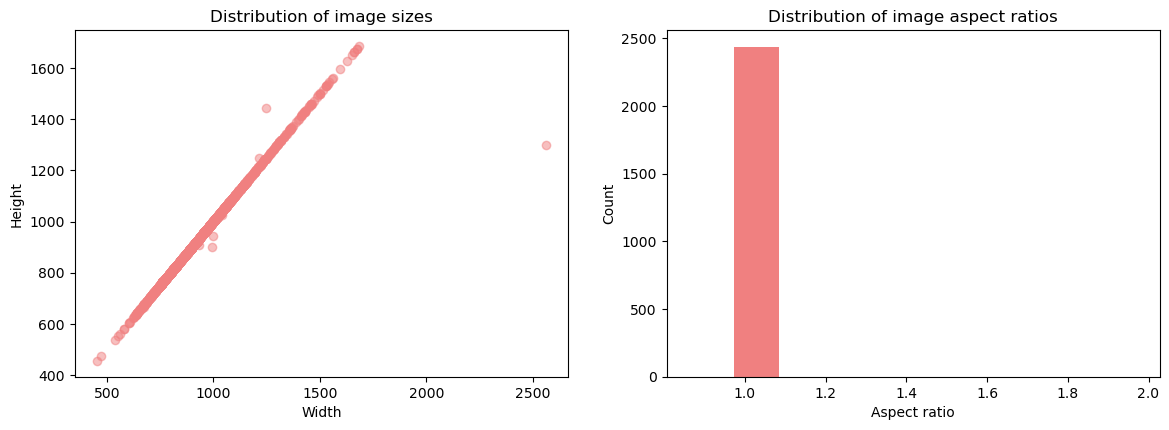

In [53]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4.5))

ax1.scatter(x = metadata['Width'], y = metadata['Height'], color = 'lightcoral', alpha = 0.5)
ax1.set_title('Distribution of image sizes'); ax1.set_xlabel('Width'); ax1.set_ylabel('Height')

ax2.hist(metadata['Aspect ratio'], color = 'lightcoral')
ax2.set_title('Distribution of image aspect ratios'); ax2.set_xlabel('Aspect ratio'); ax2.set_ylabel('Count') ;

The images have quite consistent aspect ratios of approximately 1:1; however, they vary in size, ranging from around 300x300 to 1700x1700, with one outlier of size 2500x1300 (approximately). While the framework to be used for detecting text regions (EasyOCR) does not require a specific input image size, some experimentations will be done with resizing the larger images to see if there is improvement in run time and accuracy. It is also noted that later on, once text regions are extracted (as cropped out images), sizes and aspect ratios will be examined again for outliers and necessary augmentations will be applied.

#### Visual analysis
First, 400 random images are shown to ensure that there is no unreadable file or obvious artifacts that can affect the research. This was run multiple times to cover as many samples as possible. Below is an example output:

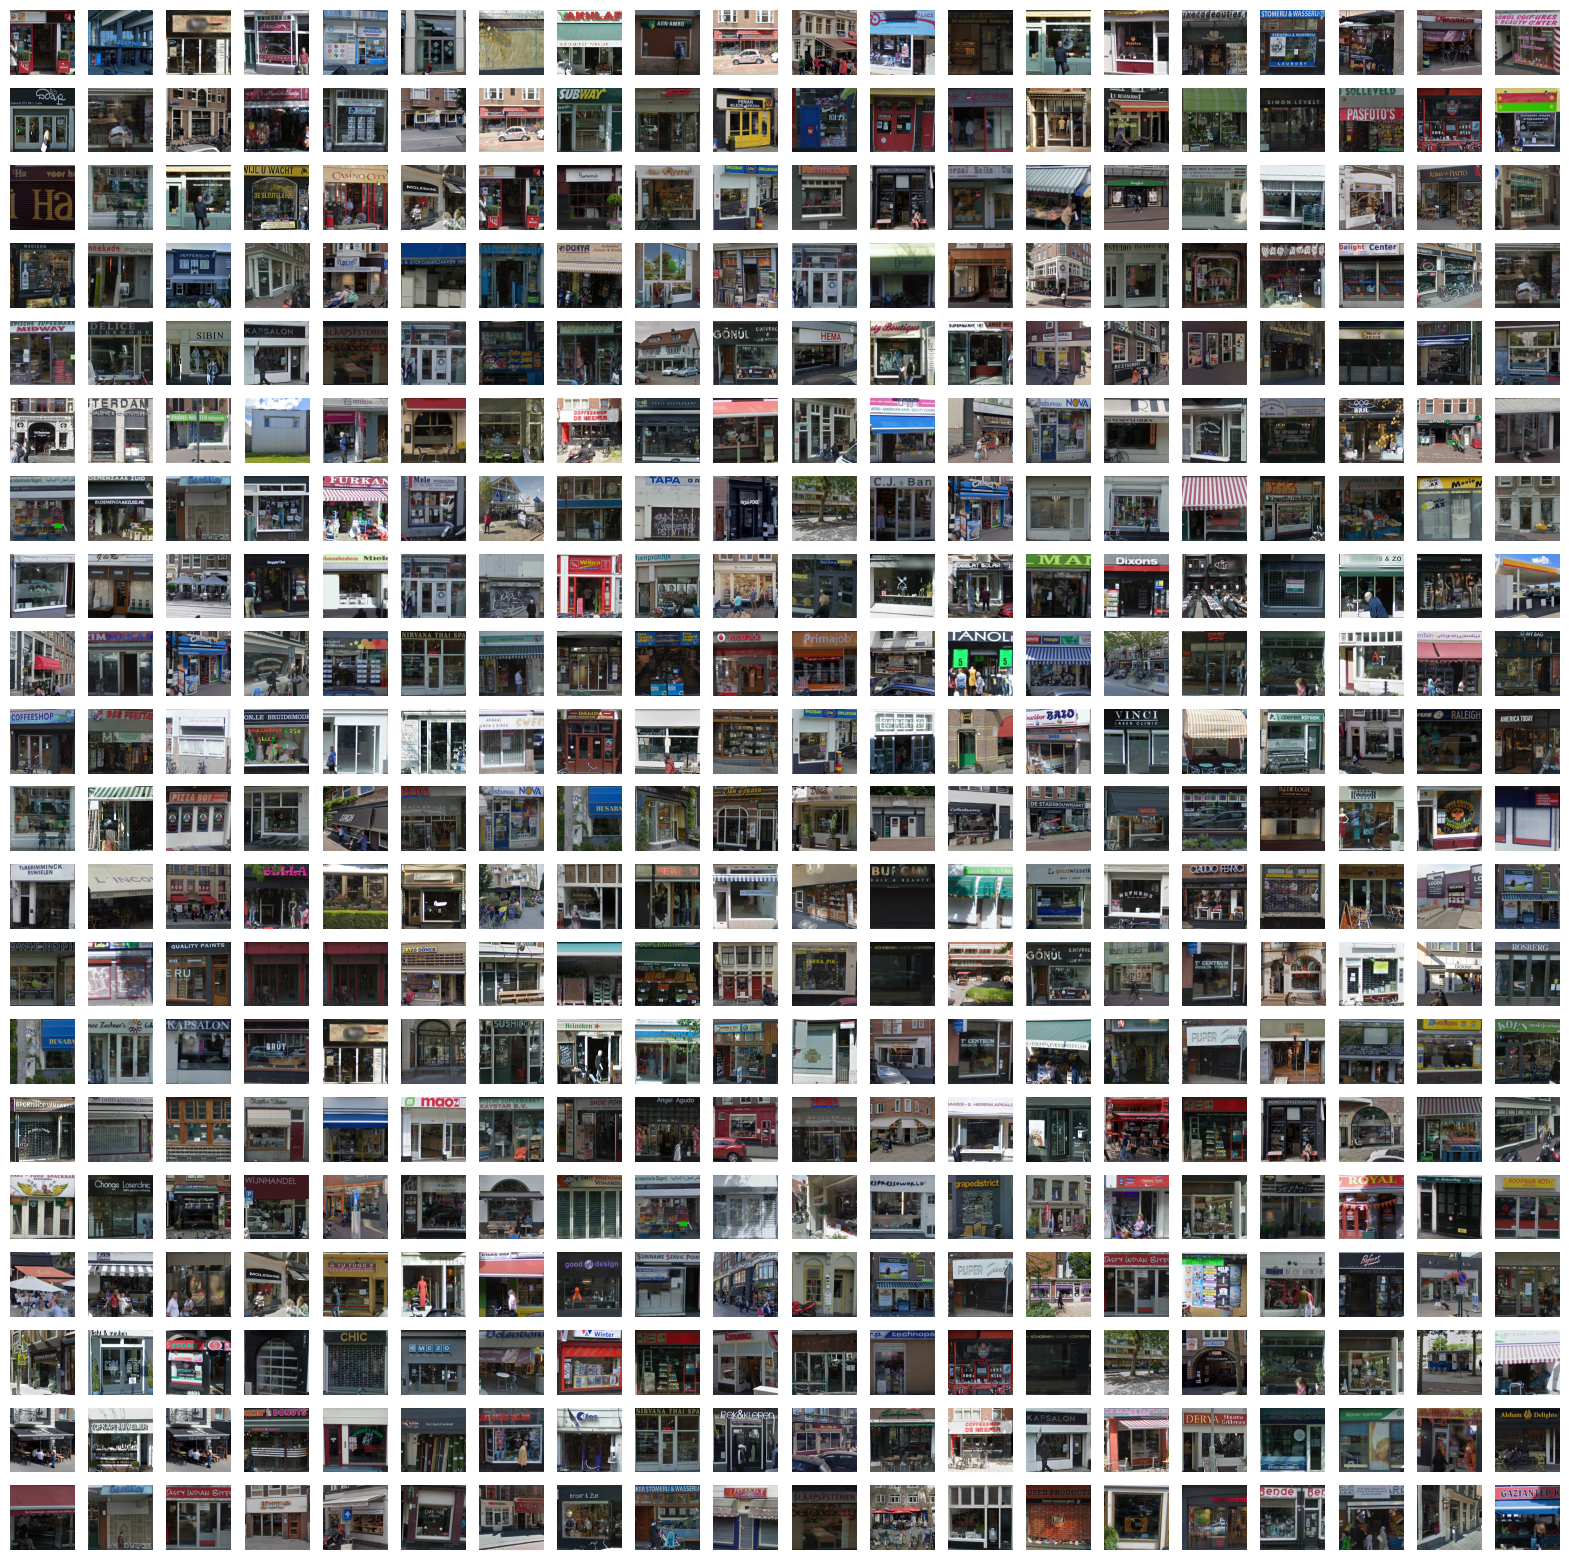

In [12]:
sample_quality = [all_images[i] for i in np.random.randint(len(all_images), size = (400))]

fig = plt.figure(figsize=(20,20))
rows, cols = 20,20

for i in range(0, cols*rows):
  fig.add_subplot(rows, cols, i+1)
  plt.imshow(sample_quality[i])
  plt.axis('off')
plt.show()

Next, a closer look is taken into sample images from each class:

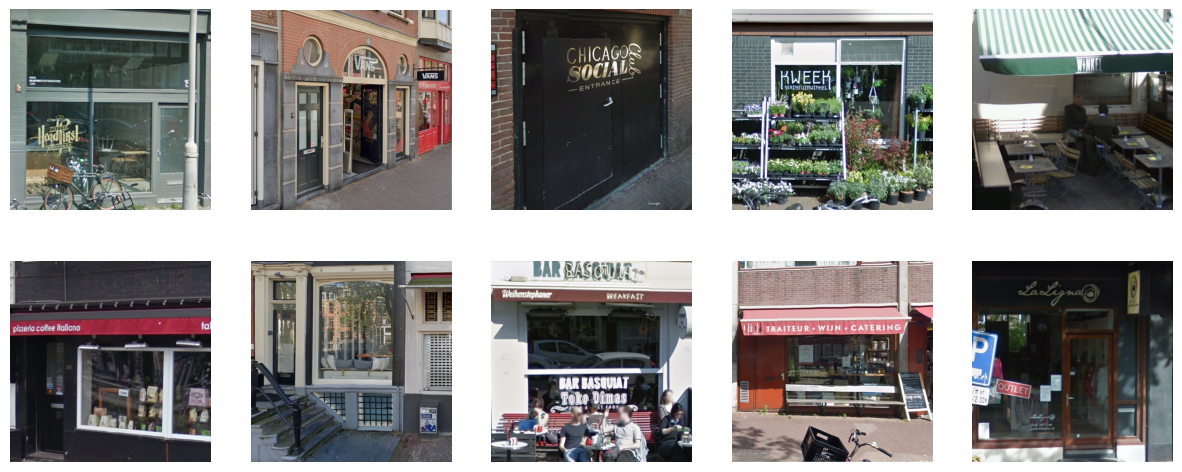

In [129]:
sample_gentrified = [gentrified[i] for i in np.random.randint(len(gentrified), size =(10))]

fig = plt.figure(figsize=(15,6))
rows, cols = 2, 5

# Display 12 random images
for i in range(0, cols*rows):
  fig.add_subplot(rows, cols, i+1)
  plt.imshow(sample_gentrified[i])
  plt.axis('off')
plt.show()

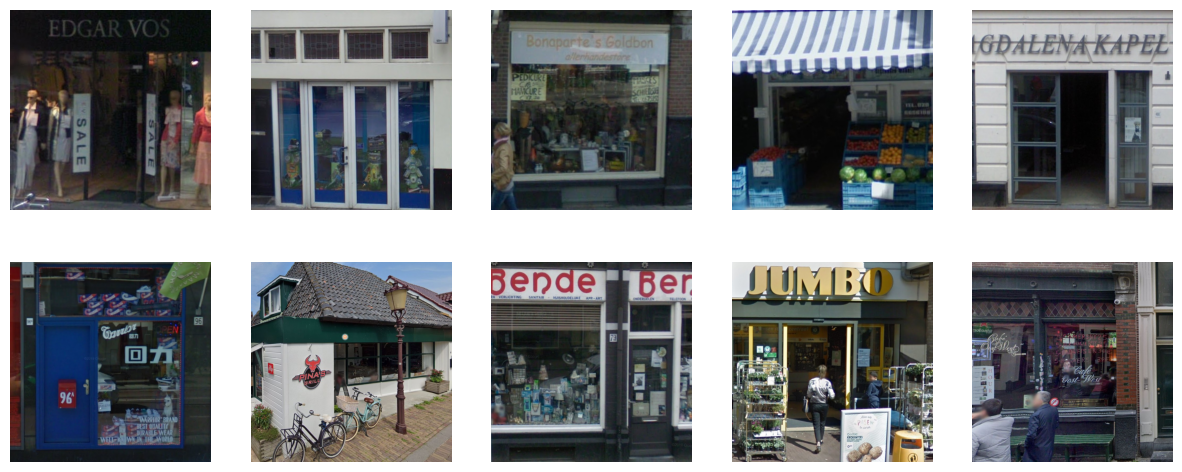

In [130]:
sample_non_gentrified = [non_gentrified[i] for i in np.random.randint(len(non_gentrified), size =(10))]

fig = plt.figure(figsize=(15,6))
rows, cols = 2, 5

# Display 12 random images
for i in range(0, cols*rows):
  fig.add_subplot(rows, cols, i+1)
  plt.imshow(sample_non_gentrified[i])
  plt.axis('off')
plt.show()

There is no significant structural difference in the images per class that might interfere with the result. In both classes, it can be seen that there is almost always text regions present. However, it can be the case that there are facades with no textual element that are just not covered in these small samples. Therefore, to better quantify this, the instances with no text detected will be noted after applying the text detection model. This could help conclude that, for instance, facades without a signage are more often seen as gentrified/non-gentrified.